<a href="https://colab.research.google.com/github/Karthikreddy1335/nlp/blob/main/14_11_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 45.4 MB/s eta 0:00:00
Word2Vec Embeddings Shape: (8, 100)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT Embeddings Shape: (8, 768)
ELMo Embeddings Shape (Simulated): (8, 100)
Applying t-SNE on Word2Vec Embeddings with perplexity=5...


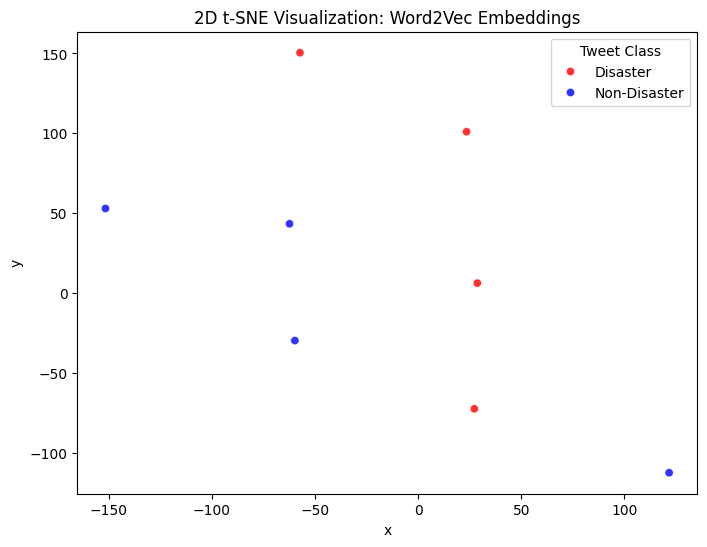

Applying t-SNE on ELMo Embeddings (Simulated) with perplexity=5...


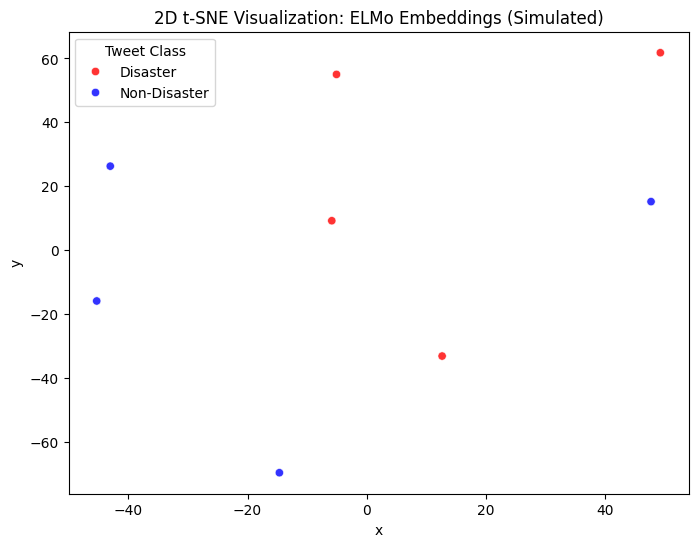

Applying t-SNE on BERT Embeddings with perplexity=5...


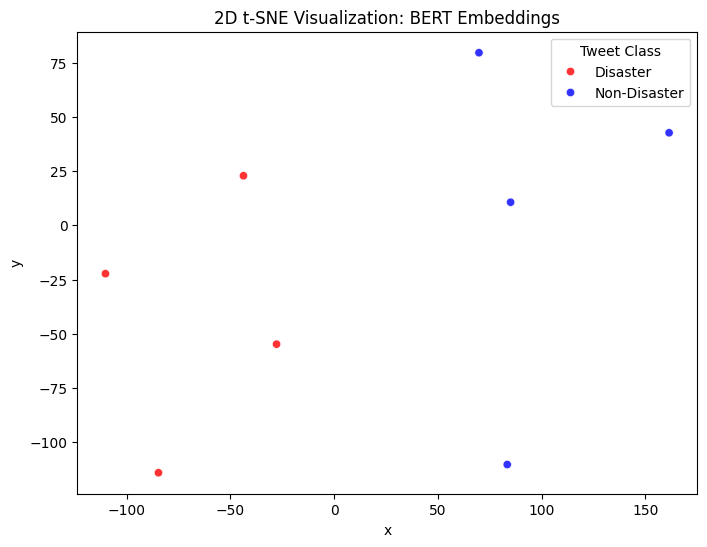

In [ ]:
!pip install gensim
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
import torch
from transformers import AutoTokenizer, AutoModel
data = {
    'clean_text': [
        'fire near la pray affected', 'saw new movie disaster lol',
        'flood warning issued new york city', 'phone slow today throw out',
        'earthquake rocks japan damage widespread', 'new album fire cant stop listening',
        'tornado hit oklahoma emergency needed', 'check cool website',
    ],
    'target': [1, 0, 1, 0, 1, 0, 1, 0]
}
df = pd.DataFrame(data)
sentences = [text.split() for text in df['clean_text']]


def get_word2vec_embeddings(sentences, vector_size=100):
    """Trains Word2Vec and averages word vectors for sentence embedding."""
    w2v_model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, workers=4)
    sentence_embeddings = []

    for sentence in sentences:
        vectors = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
        if vectors:
            sentence_embeddings.append(np.mean(vectors, axis=0))
        else:
            sentence_embeddings.append(np.zeros(vector_size))

    return np.array(sentence_embeddings)

def get_bert_embeddings(texts):
    """Extracts BERT [CLS] token embeddings (sentence embedding)."""
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')

    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=64)

    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

w2v_embeddings = get_word2vec_embeddings(sentences, vector_size=100)
print(f"Word2Vec Embeddings Shape: {w2v_embeddings.shape}")

bert_embeddings = get_bert_embeddings(df['clean_text'].tolist())
print(f"BERT Embeddings Shape: {bert_embeddings.shape}")

elmo_embeddings = np.random.rand(*w2v_embeddings.shape)
print(f"ELMo Embeddings Shape (Simulated): {elmo_embeddings.shape}")



def visualize_embeddings(embeddings, title, labels):
    """Applies t-SNE directly on the embeddings and plots the 2D results."""

    n_samples = embeddings.shape[0]
    safe_perplexity = min(5, n_samples - 1)


    print(f"Applying t-SNE on {title} with perplexity={safe_perplexity}...")

    tsne = TSNE(n_components=2, random_state=42, perplexity=safe_perplexity)
    embeddings_2d = tsne.fit_transform(embeddings)

    df_plot = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
    df_plot['label'] = labels
    df_plot['class'] = df_plot['label'].apply(lambda x: 'Disaster' if x == 1 else 'Non-Disaster')

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='x', y='y',
        hue='class',
        data=df_plot,
        palette=['red', 'blue'],
        alpha=0.8
    )
    plt.title(f'2D t-SNE Visualization: {title}')
    plt.legend(title='Tweet Class')
    plt.show()

labels = df['target'].values
visualize_embeddings(w2v_embeddings, "Word2Vec Embeddings", labels)
visualize_embeddings(elmo_embeddings, "ELMo Embeddings (Simulated)", labels)
visualize_embeddings(bert_embeddings, "BERT Embeddings", labels)